# Notebook: BERTopic to analyse the Topics

## 1. Load Packages

In [1]:
from plots import plot_topic_subplots, plot_timeseries_subplots, plot_timeseries_sentiment_subplots
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bertopic import BERTopic
from gensim import corpora
import pandas as pd
import numpy as np
import random
import torch
import math
import nltk 
import re

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/min

## 2. Constants / Setup

In [2]:
N_TOPICS = 26
RANDOM_STATE = 42
TOP_N_WORDS = 100
FONT_PATH_WORDCLOUDS = 'fonts/manrope-regular.otf'

In [3]:
DATASET_MENTIONS_PATH = "../Datasets/tweets_mentions.csv"
DATASET_MENTIONS_IMG_PATH = "../Datasets/img_dataset_mentions/images_dataset.csv"
DATASET_POLITICAL_ACCOUNTS_PATH = "../Datasets/tweets_political_accounts.csv"
DATASET_POLITICAL_ACCOUNTS_IMG_PATH = "../Datasets/img_dataset_political_accounts/images_dataset.csv"

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nils_hellwig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopwords = set(stopwords.words("german")).union(set(stopwords.words("english")))
stopwords.update(["ja", "nein", "mal", "nein", "schon", "immer", "utm", "the", "to", "mehr", "com", "geht", "heute", "https", "thread", "anzeigen", "https", "http", "www", "co", "de", "html", "nehmen", "habt", "hast", "tut", "gibt", "wäre", "steht", "ganz", "usw", "ging", "seid", "liegt", "sagen", "finde", "denen", "übrigens", "trotzdem", "darauf", "hätte", "wer", "sogar", "weiß"])

In [6]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

## 3. Load Dataset

In [7]:
df_mentions = pd.read_csv(DATASET_MENTIONS_PATH)
df_mentions

Unnamed: 0                                               text   
0                0  Wichtige wissenschaftliche Erkenntnis- nun mus...  \
1                1  @KarambaDiaby @HalleSpd @SPD_LSA Ich gratulier...   
2                2  @KarambaDiaby @HalleSpd @SPD_LSA Herzlichen Gl...   
3                3  @KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...   
4                4      @KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch.   
...            ...                                                ...   
707236      707236  @b_riexinger Klima oder Verkehr fast gleich......   
707237      707237  @b_riexinger @Linksfraktion Na ob das noch lan...   
707238      707238           @b_riexinger Ich wünsch Dir viel Erfolg.   
707239      707239  @b_riexinger Nun, da gibt es ja genügend zu tu...   
707240      707240  @b_riexinger Wünsche dir gutes Gelingen lieber...   

       source_party source_account                 date  sentiment  
0               SPD   KarambaDiaby  2021-01-09 19:35:29          0  
1               SPD   KarambaDiaby  2021-01-09 17:09:28          0  
2               SPD   KarambaDiaby  2021-01-09 13:16:13          0  
3               SPD   KarambaDiaby  2021-01-09 12:32:40          1  
4               SPD   KarambaDiaby  2021-01-09 12:13:06          0  
...             ...            ...                  ...        ...  
707236        LINKE    b_riexinger  2021-12-17 08:19:23          1  
707237        LINKE    b_riexinger  2021-12-17 08:18:07          1  
707238        LINKE    b_riexinger  2021-12-17 07:47:59          0  
707239        LINKE    b_riexinger  2021-12-17 02:07:26          2  
707240        LINKE    b_riexinger  2021-12-17 01:02:05          0  

[707241 rows x 6 columns]

In [8]:
df_political_accounts_img = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_IMG_PATH)
df_political_accounts_img = df_political_accounts_img.rename(columns={'extracted_text': 'text'})
df_political_accounts_img

Unnamed: 0             tweet_id  image_index   
0               0  1377157230630301700            0  \
1               1  1377486425499832320            0   
2               2  1379754099609047040            0   
3               3  1381254353336606721            0   
4               4  1381863885666406400            0   
...           ...                  ...          ...   
21954       21954  1350695518536683524            0   
21955       21955  1351083430218493953            0   
21956       21956  1352556008934137858            0   
21957       21957  1462488643638108170            0   
21958       21958  1472498789122514945            0   

                        filename   
0      1377157230630301700_0.jpg  \
1      1377486425499832320_0.jpg   
2      1379754099609047040_0.jpg   
3      1381254353336606721_0.jpg   
4      1381863885666406400_0.jpg   
...                          ...   
21954  1350695518536683524_0.jpg   
21955  1351083430218493953_0.jpg   
21956  1352556008934137858_0.jpg   
21957  1462488643638108170_0.jpg   
21958  1472498789122514945_0.jpg   

                                                    text   
0      Behördenwillkür\n\n\C\n\nD Es wird Zeit, den B...  \
1                                                    NaN   
2      IREBSSWEE Folgen\n\n* So geht es nicht weiter!...   
3      6% Die Landesvorsitzende der AfD\nBerlin kriti...   
4                                                    NaN   
...                                                  ...   
21954  Deutsches\nRotes\nKreuz\n\nServiceportal zur I...   
21955  Deutschland droht der Mega-Lockdown -\n\nobwoh...   
21956           ‚ . Die verlorene\nSchülergeneration\n\n   
21957  zur Impfpflicht! B |\n\nTino Chrupalla Bundess...   
21958                                      Alice Weide\n   

                                                     url   
0      https://pbs.twimg.com/media/ExylKvEU8AgowSU?fo...  \
1      https://pbs.twimg.com/media/Ev5cqNvWgAYX_Fl?fo...   
2      https://pbs.twimg.com/media/EyXfBlTWEAEfrHg?fo...   
3      https://pbs.twimg.com/media/EyszgrWXEAEqXID?fo...   
4      https://pbs.twimg.com/media/Ey1d1VqWQAACVNs?fo...   
...                                                  ...   
21954  https://pbs.twimg.com/media/Er6iaV7XAAIkOIp?fo...   
21955  https://pbs.twimg.com/media/EsADN8IXAAAnR7o?fo...   
21956  https://pbs.twimg.com/media/EsU-hOsXYAAQyIO?fo...   
21957  https://pbs.twimg.com/media/FEvNqgDWUAUD_5i?fo...   
21958  https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?fo...   

                                              image_path source_party   
0      ../Datasets/img_dataset_politicians/AFD/AfDBer...          AFD  \
1      ../Datasets/img_dataset_politicians/AFD/AfDBer...          AFD   
2      ../Datasets/img_dataset_politicians/AFD/AfDBer...          AFD   
3      ../Datasets/img_dataset_politicians/AFD/AfDBer...          AFD   
4      ../Datasets/img_dataset_politicians/AFD/AfDBer...          AFD   
...                                                  ...          ...   
21954  ../Datasets/img_dataset_politicians/AFD/Tino_C...          AFD   
21955  ../Datasets/img_dataset_politicians/AFD/Tino_C...          AFD   
21956  ../Datasets/img_dataset_politicians/AFD/Tino_C...          AFD   
21957  ../Datasets/img_dataset_politicians/AFD/Tino_C...          AFD   
21958  ../Datasets/img_dataset_politicians/AFD/Tino_C...          AFD   

       source_account                 date  
0           AfDBerlin  2021-03-31 07:14:04  
1           AfDBerlin  2021-04-01 05:02:10  
2           AfDBerlin  2021-04-07 11:13:06  
3           AfDBerlin  2021-04-11 14:34:34  
4           AfDBerlin  2021-04-13 06:56:38  
...               ...                  ...  
21954  Tino_Chrupalla  2021-01-17 06:44:40  
21955  Tino_Chrupalla  2021-01-18 08:26:06  
21956  Tino_Chrupalla  2021-01-22 09:57:36  
21957  Tino_Chrupalla  2021-11-21 18:30:39  
21958  Tino_Chrupalla  2021-12-19 09:27:23  

[21959 rows x 10 columns]

In [9]:
df_politicians = pd.read_csv(DATASET_POLITICAL_ACCOUNTS_PATH)
df_politicians

Unnamed: 0  UserScreenName  source_account                 date   
0               0      AfD Berlin       AfDBerlin  2021-03-26 21:07:22  \
1               1      AfD Berlin       AfDBerlin  2021-03-27 07:20:27   
2               2      AfD Berlin       AfDBerlin  2021-03-31 07:14:04   
3               3      AfD Berlin       AfDBerlin  2021-04-01 14:29:00   
4               4      AfD Berlin       AfDBerlin  2021-04-01 05:02:10   
...           ...             ...             ...                  ...   
58859       58859  Tino Chrupalla  Tino_Chrupalla  2021-12-04 17:26:46   
58860       58860  Tino Chrupalla  Tino_Chrupalla  2021-12-13 16:30:19   
58861       58861  Tino Chrupalla  Tino_Chrupalla  2021-12-17 14:02:24   
58862       58862  Tino Chrupalla  Tino_Chrupalla  2021-12-19 09:27:23   
58863       58863  Tino Chrupalla  Tino_Chrupalla  2021-12-23 13:40:49   

                                                    Text   
0                    AfD Berlin\n@AfDBerlin\n·\n26. März  \
1                    AfD Berlin\n@AfDBerlin\n·\n27. März   
2                    AfD Berlin\n@AfDBerlin\n·\n31. März   
3                     AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
4                     AfD Berlin\n@AfDBerlin\n·\n1. Apr.   
...                                                  ...   
58859   Tino Chrupalla\n@Tino_Chrupalla\n·\n4. Dez. 2021   
58860  Tino Chrupalla\n@Tino_Chrupalla\n·\n13. Dez. 2021   
58861  Tino Chrupalla\n@Tino_Chrupalla\n·\n17. Dez. 2021   
58862  Tino Chrupalla\n@Tino_Chrupalla\n·\n19. Dez. 2021   
58863  Tino Chrupalla\n@Tino_Chrupalla\n·\n23. Dez. 2021   

                                                    text Emojis Comments   
0      AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...    NaN      4.0  \
1      Im Herbst wird gewählt.\nSchluss mit den Recht...    NaN     10.0   
2      Behördenwillkür\nFlüchtlingsheime durchgedrück...    NaN      3.0   
3      Aus Raider wird jetzt Twix \n\nLeider kein #Ap...    NaN      1.0   
4      Gendern geht („*innen“)\nImpfen geht nicht.\nD...    NaN      1.0   
...                                                  ...    ...      ...   
58859  Friedlicher Protest gegen einen #Impfzwang ist...    NaN    265.0   
58860  @OlafScholz\n muss sich endlich klar zu Nord S...    NaN      4.0   
58861  Mit \n@_FriedrichMerz\n gibt es keine konserva...    NaN    188.0   
58862  Wir wünschen Ihnen und Ihrer Familie einen bes...    NaN    449.0   
58863  @_FriedrichMerz\n will parlamentarische Zusamm...    NaN      9.0   

       Likes Retweets                                             photos   
0       28.0    132.0  ['https://pbs.twimg.com/profile_images/1037343...  \
1       20.0    112.0  ['https://pbs.twimg.com/card_img/1471780757332...   
2       13.0     34.0  ['https://pbs.twimg.com/media/ExylKvEU8AgowSU?...   
3        4.0     17.0  ['https://pbs.twimg.com/card_img/1472910546907...   
4        3.0     16.0  ['https://pbs.twimg.com/profile_images/9706413...   
...      ...      ...                                                ...   
58859  122.0    578.0                                                 []   
58860    2.0     11.0                                                 []   
58861  227.0    1.008                                                 []   
58862  346.0    2.648  ['https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?...   
58863    4.0     11.0  ['https://pbs.twimg.com/card_img/1481535392549...   

                                               Tweet URL     id source_party   
0      https://twitter.com/AfDBerlin/status/137555499...      1          AFD  \
1      https://twitter.com/AfDBerlin/status/137570928...      2          AFD   
2      https://twitter.com/AfDBerlin/status/137715723...      3          AFD   
3      https://twitter.com/AfDBerlin/status/137762907...      4          AFD   
4      https://twitter.com/AfDBerlin/status/137748642...      5          AFD   
...                                                  ...    ...          ...   
58859  http

In [10]:
df_mentions_img = pd.read_csv(DATASET_MENTIONS_IMG_PATH)
df_mentions_img = df_mentions_img.rename(columns={'extracted_text': 'text'})
df_mentions_img

Unnamed: 0             tweet_id  image_index   
0               0  1345866502268985354            0  \
1               1  1345863370579320832            0   
2               2  1345860999602184196            0   
3               3  1345841888289550345            0   
4               4  1345840672113373186            0   
...           ...                  ...          ...   
34136       34136  1438112331666530313            1   
34137       34137  1438111715409936387            0   
34138       34138  1444703262951759880            0   
34139       34139  1446709991805751297            0   
34140       34140  1471084101285330949            0   

                        filename   
0      1345866502268985354_0.jpg  \
1      1345863370579320832_0.jpg   
2      1345860999602184196_0.jpg   
3      1345841888289550345_0.jpg   
4      1345840672113373186_0.jpg   
...                          ...   
34136  1438112331666530313_1.jpg   
34137  1438111715409936387_0.jpg   
34138  1444703262951759880_0.jpg   
34139  1446709991805751297_0.jpg   
34140  1471084101285330949_0.jpg   

                                                    text   
0                                                    NaN  \
1                                 Asyl- |\nmißbrauch\n\n   
2      kann, dass dieses '\n\nGesindel\n\nwieder vers...   
3      25. Februar 2011, 11:45 Uhr FDPrudert zurück\n...   
4      You can fool some of the people all of the tim...   
...                                                  ...   
34136                                                NaN   
34137                                                NaN   
34138  Zusammenhalten.\nFür Gerechtigkeit.\nDIE LINKE.\n   
34139  Das umgekehrte Bild bei der\n\nLinken: Sie ver...   
34140                                                NaN   

                                                   url   
0      https://pbs.twimg.com/media/Eq16c2qXYAwa__x.jpg  \
1      https://pbs.twimg.com/media/Eq13meUXEAMWanr.jpg   
2      https://pbs.twimg.com/media/Eq11cdkW8AU8leb.jpg   
3      https://pbs.twimg.com/media/Eq1kEA2XUAAyW_f.jpg   
4      https://pbs.twimg.com/media/Eq1i03_W4AANqWe.png   
...                                                ...   
34136  https://pbs.twimg.com/media/E_UzixMXoAg5Bay.jpg   
34137  https://pbs.twimg.com/media/E_Uy-8FWYAUkFY5.jpg   
34138  https://pbs.twimg.com/media/FAyahiCXoAI6Kzy.jpg   
34139  https://pbs.twimg.com/media/FBO-9t7WEAkN-fA.jpg   
34140  https://pbs.twimg.com/media/FGpWnSNXsAMQvSq.png   

                                              image_path source_party   
0      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU  \
1      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
2      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
3      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
4      ../Datasets/img_dataset_mentions/CDU_CSU/Armin...      CDU_CSU   
...                                                  ...          ...   
34136  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
34137  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
34138  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
34139  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   
34140  ../Datasets/img_dataset_mentions/LINKE/b_riexi...        LINKE   

      source_account                 date  
0       ArminLaschet  2021-01-03 22:55:53  
1       ArminLaschet  2021-01-03 22:43:27  
2       ArminLaschet  2021-01-03 22:34:01  
3       ArminLaschet  2021-01-03 21:18:05  
4       ArminLaschet  2021-01-03 21:13:15  
...              ...                  ...  
34136    b_riexinger  2021-09-15 13:07:53  
34137    b_riexinger  2021-09-15 13:05:26  
34138    b_riexinger  2021-10-03 17:37:53  
34139    b_riexinger  2021-10-09 06:31:55  
34140    b_riexinger  2021-12-15 11:45:55  

[34141 rows x 10 columns]

## 4. Code

#### Clean Data

In [11]:
df = df_politicians.copy()

In [12]:
df['date'] = pd.to_datetime(df['date'])
months = df['date'].dt.month.to_list()

In [13]:
def remove_stopwords_and_clean(data):
    
    def clean_text(text):
        RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
        RE_TAGS = re.compile(r"<[^>]+>")
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

        text = re.sub(r'@\w+', '', text)
        text = re.sub(RE_TAGS, " ", text)
        text = re.sub(RE_ASCII, " ", text)
        text = re.sub(RE_SINGLECHAR, " ", text)
        text = re.sub(RE_WSPACE, " ", text)
        return text
    
    output_array = []
    for sentence in data:
        if type(sentence) != str:
            sentence = ""
        sentence = clean_text(sentence)
        temp_list = [word for word in sentence.split() if word.lower() not in stopwords]
        output_array.append(' '.join(temp_list))
    
    return output_array

In [14]:
cleaned_text = remove_stopwords_and_clean(df.text.to_list())

#### Train BERTopic

In [15]:
from umap import UMAP

# These are the default parameters (see here: https://github.com/MaartenGr/BERTopic/blob/15ea0cd804d35c1f11c6692f33c3666b648dd6c8/bertopic/_bertopic.py#L156-L160) but additionally, I added a random state
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=RANDOM_STATE)

In [16]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [17]:
model = BERTopic(language="german", hdbscan_model=hdbscan_model, nr_topics=N_TOPICS, umap_model=umap_model, top_n_words=TOP_N_WORDS)

In [18]:
topics, probabilities = model.fit_transform(cleaned_text)


KeyboardInterrupt



In [19]:
topics = model.reduce_outliers(cleaned_text, topics, strategy="distributions")

In [20]:
model.update_topics(cleaned_text, topics, top_n_words=TOP_N_WORDS)

In [21]:
topics_over_time = model.topics_over_time(cleaned_text, months)

In [22]:
topics_over_time

Topic                                              Words  Frequency  \
0       -1  wienerphilharmoniker, berechtigungsscheine, te...          3   
1        0                  jan, cdu, afd, antwort, bundestag       3630   
2        1        klimaschutz, klima, grünen, klimakrise, jan        221   
3        2          impfstoff, corona, covid, impfen, impfung        698   
4        3           schuldenbremse, euro, rente, eu, steuern        198   
..     ...                                                ...        ...   
301     20            woche, satire, zeller, cartoon, antwort         23   
302     21               norden, ndr, frühstück, info, schnee         38   
303     22  buchungsplattformen, gatekeeper, dma, tourismu...          8   
304     23                   day, happy, best, croatia, today         17   
305     24  blockiert, vielfalt, höflichen, biologischer, ...          4   

     Timestamp  
0            1  
1            1  
2            1  
3            1  
4            1  
..         ...  
301         12  
302         12  
303         12  
304         12  
305         12  

[306 rows x 4 columns]

In [23]:
n_topics = N_TOPICS - 1
document_info = model.get_document_info(cleaned_text)
topics_over_time["Name"] = topics_over_time["Topic"].apply(lambda x: document_info[document_info["Topic"] == x]["Name"].iloc[0])
document_info["date"] = df["date"]
if 'sentiment' in df.columns:
    document_info["sentiment"] = df["sentiment"]
document_info["month"] = df['date'].dt.month

In [24]:
model.get_document_info(cleaned_text)[model.get_document_info(cleaned_text)["Topic"] == 1]

Document  Topic  \
32                          Staatsfunk berichtet neutral      1   
43     NEWS Höheren deutsche Steuern verändern global...      1   
94     Polizei sicher ans Ziel gelangen fährt Verbren...      1   
156    Folgetag Versprochen nicola brüning Sep Hallo ...      1   
172    steuer subventionierte Vogelschredder gerne Wa...      1   
...                                                  ...    ...   
58744  Verkehrswende Preise Bus Bahn müssen sinken gl...      1   
58746  FDP GRÜNE Bahn Rückgrat Verkehrswende zerschla...      1   
58786  Sozialer Aufbruch dröger Scholz Regierungserkl...      1   
58841  Tausende Windkraftanlagen bald Ende müssen ent...      1   
58845  Bürger Landes brauchen dringend Realismus Vern...      1   

                                  Name  \
32     1_klimaschutz_klima_grünen_beim   
43     1_klimaschutz_klima_grünen_beim   
94     1_klimaschutz_klima_grünen_beim   
156    1_klimaschutz_klima_grünen_beim   
172    1_klimaschutz_klima_grünen_beim   
...                                ...   
58744  1_klimaschutz_klima_grünen_beim   
58746  1_klimaschutz_klima_grünen_beim   
58786  1_klimaschutz_klima_grünen_beim   
58841  1_klimaschutz_klima_grünen_beim   
58845  1_klimaschutz_klima_grünen_beim   

                                             Top_n_words  Probability  \
32     klimaschutz - klima - grünen - beim - klimakri...     0.000000   
43     klimaschutz - klima - grünen - beim - klimakri...     0.742486   
94     klimaschutz - klima - grünen - beim - klimakri...     1.000000   
156    klimaschutz - klima - grünen - beim - klimakri...     0.000000   
172    klimaschutz - klima - grünen - beim - klimakri...     0.841576   
...                                                  ...          ...   
58744  klimaschutz - klima - grünen - beim - klimakri...     1.000000   
58746  klimaschutz - klima - grünen - beim - klimakri...     1.000000   
58786  klimaschutz - klima - grünen - beim - klimakri...     0.000000   
58841  klimaschutz - klima - grünen - beim - klimakri...     1.000000   
58845  klimaschutz - klima - grünen - beim - klimakri...     1.000000   

       Representative_document  
32                       False  
43                       False  
94                       False  
156                      False  
172                      False  
...                        ...  
58744                    False  
58746                    False  
58786                    False  
58841                    False  
58845                    False  

[5089 rows x 6 columns]

In [25]:
model.get_document_info(cleaned_text)["Topic"].value_counts()

 0     36263
 2      5878
 1      5089
 3      2034
 4      1925
 6      1286
 5       886
 7       619
 8       598
 15      434
 16      406
 10      334
 12      317
 19      316
 11      312
 9       308
 21      302
 17      288
 13      219
 23      215
 20      213
 14      206
 22      198
 18      102
 24       96
-1        20
Name: Topic, dtype: int64

In [26]:
import pandas as pd

df_topics = pd.DataFrame()

for i in range(n_topics):
    topic = model.get_topic(i)
    words = [word[0] for word in topic]
    scores = [word[1] for word in topic]
    
    df_topics[f"topic_{i}_word"] = words
    df_topics[f"topic_{i}_score"] = scores

df_topics.to_csv("plots/topic_scores.csv")
df_topics

topic_0_word  topic_0_score topic_1_word  topic_1_score topic_2_word  \
0           afd       0.014150  klimaschutz       0.049176       corona   
1           cdu       0.013414        klima       0.020269        covid   
2     bundestag       0.012998       grünen       0.017572       impfen   
3        berlin       0.011324         beim       0.015468      impfung   
4           spd       0.010662   klimakrise       0.015249    impfstoff   
..          ...            ...          ...            ...          ...   
95         darf       0.003674     schützen       0.004644        fälle   
96        statt       0.003634       morgen       0.004577       bayern   
97         zwei       0.003624           eu       0.004554        dafür   
98        abend       0.003609      deshalb       0.004532       leider   
99      gestern       0.003590    gemeinsam       0.004491      omicron   

    topic_2_score        topic_3_word  topic_3_score topic_4_word  \
0        0.031288               rente       0.039501      schulen   
1        0.029177                euro       0.030733       kinder   
2        0.026696             steuern       0.027842       corona   
3        0.025497                  eu       0.025285     pandemie   
4        0.024288      schuldenbremse       0.021423       schule   
..            ...                 ...            ...          ...   
95       0.004505                 faz       0.005213   lauterbach   
96       0.004481  mindestbesteuerung       0.005171        junge   
97       0.004473            deutsche       0.005100      braucht   
98       0.004450          kommission       0.005098      sollten   
99       0.004410            arbeiten       0.005096     bekommen   

    topic_4_score  ... topic_20_word  topic_20_score topic_21_word  \
0        0.054825  ...         woche        0.116142        norden   
1        0.054008  ...        satire        0.095012     frühstück   
2        0.041201  ...         humor        0.088383           ice   
3        0.024698  ...        zeller        0.081983     marktgang   
4        0.022023  ...       cartoon        0.075568        schnee   
..            ...  ...           ...             ...           ...   
95       0.004736  ...      ironisch        0.007246           feb   
96       0.004666  ...     halloween        0.007246        ganzen   
97       0.004616  ...      schäuble        0.007233          wohl   
98       0.004540  ...          herr        0.007146    landschaft   
99       0.004539  ...        royale        0.007075         fette   

    topic_21_score         topic_22_word  topic_22_score topic_23_word  \
0         0.099127             tourismus        0.083928           day   
1         0.051565  stegnertourbundestag        0.069389       friends   
2         0.050486                reisen        0.048066         today   
3         0.047001           gastronomie        0.045487         happy   
4         0.044241               station        0.044581          best   
..             ...                   ...             ...           ...   
95        0.007001                müssen        0.007552       croatia   
96        0.006895             ausfüllen        0.007410      slovakia   
97        0.006851           gespeichert        0.007410      thoughts   
98        0.006732           unternehmen        0.007340       working   
99        0.006732             strategie        0.007302         close   

    topic_23_score         topic_24_word  topic_24_score  
0         0.107884  insektenschutzgesetz        0.093516  
1         0.071106        insektenschutz        0.091705  
2         0.062469             pestizide        0.059484  
3         0.055800                bienen        0.054077  
4         0.043559           beschlossen        0.049255  
..             ...                   ...             ...  
95        0.008062          biologischen        0.011825  
96        0.008062                blühen        0.011825  
97        0.

36263


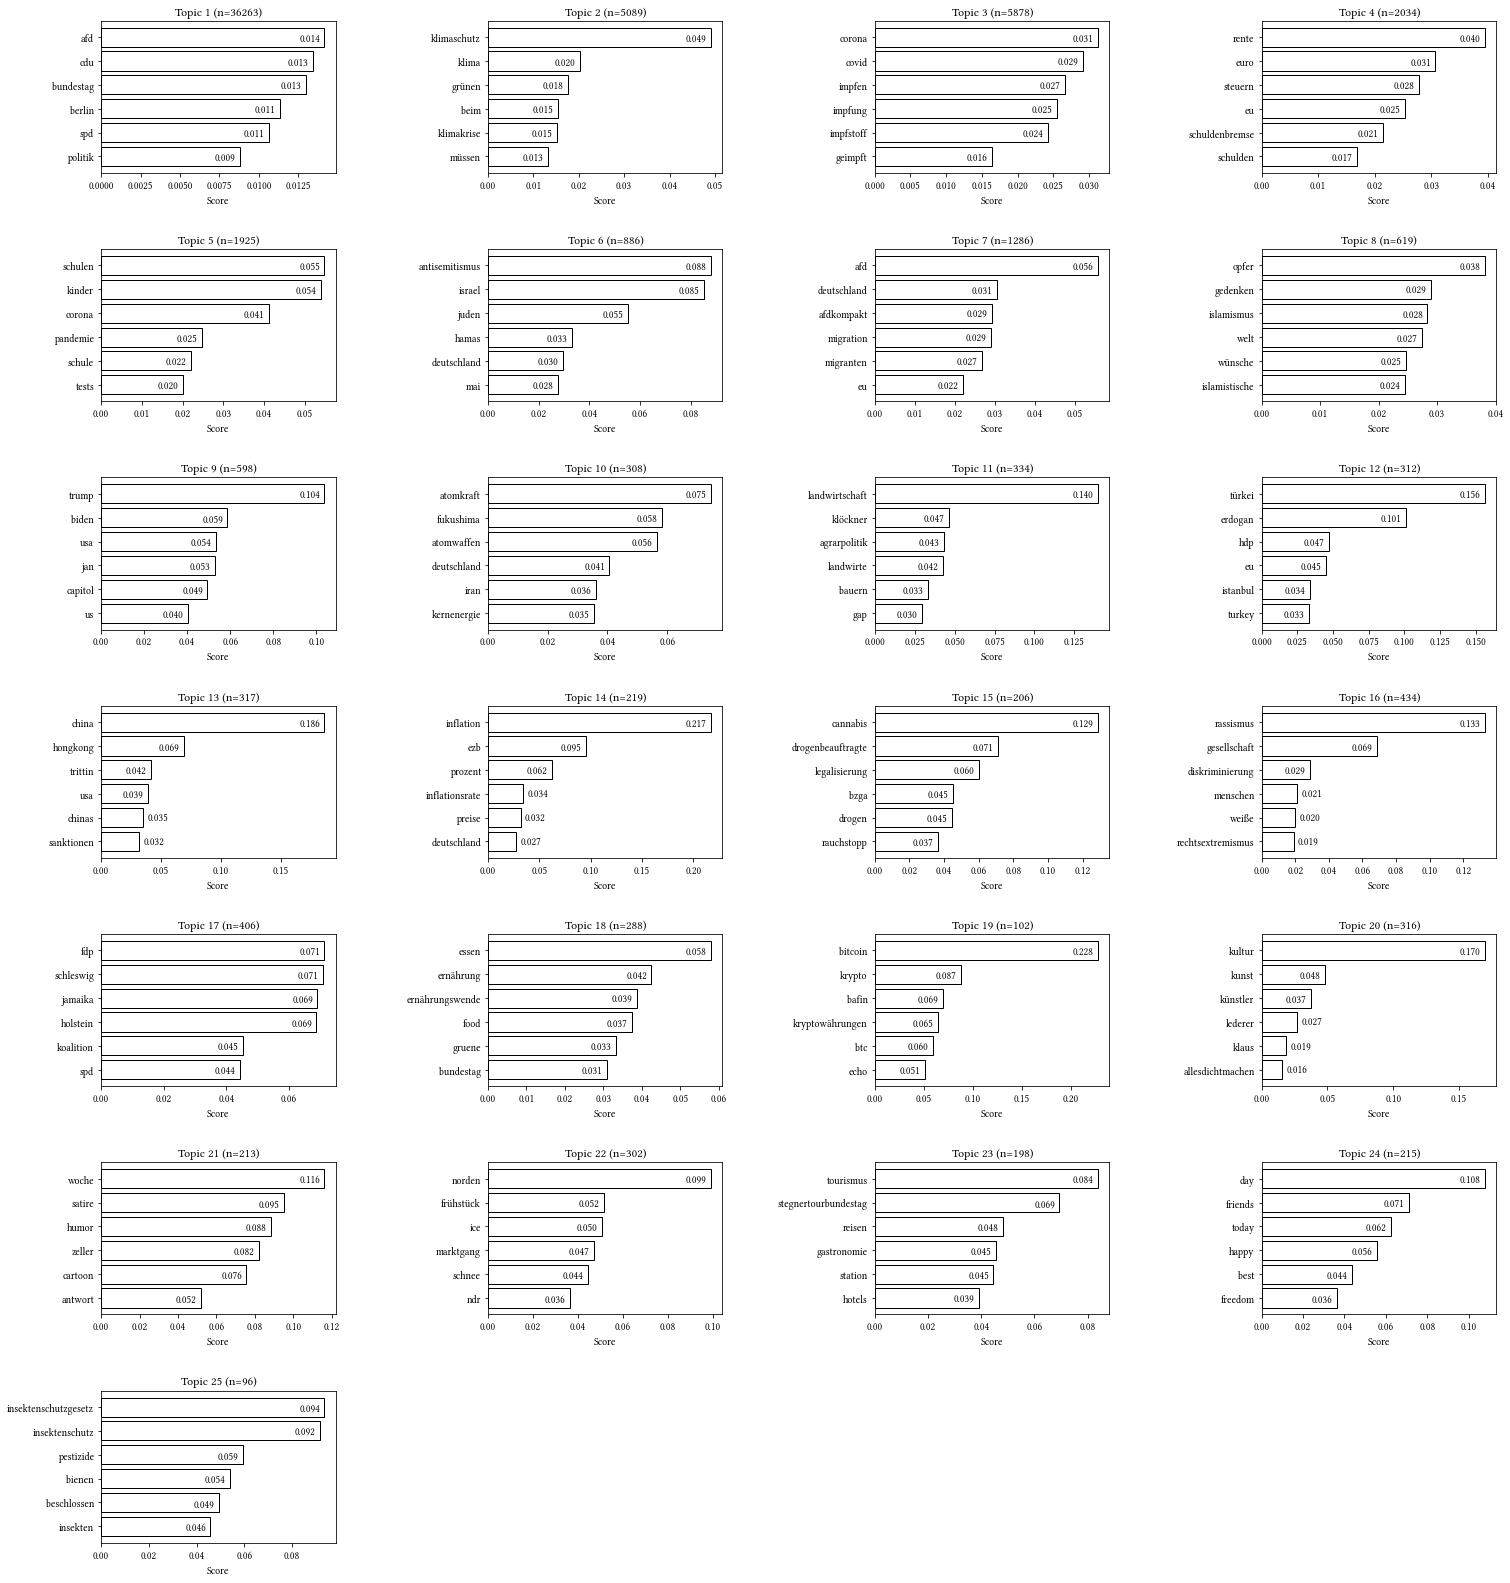

In [27]:
plot_topic_subplots(df_topics, n_topics, document_info["Topic"].value_counts(), filename="plots/top5_topics")

A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [28]:
fig = model.visualize_hierarchy(width=2000, height=2000)
fig.write_html("plots/hirachy.html")

Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [29]:
fig = model.visualize_heatmap(width=2000, height=2000)#(cleaned_text)
fig.write_html("plots/heatmap.html")

### Topics over time

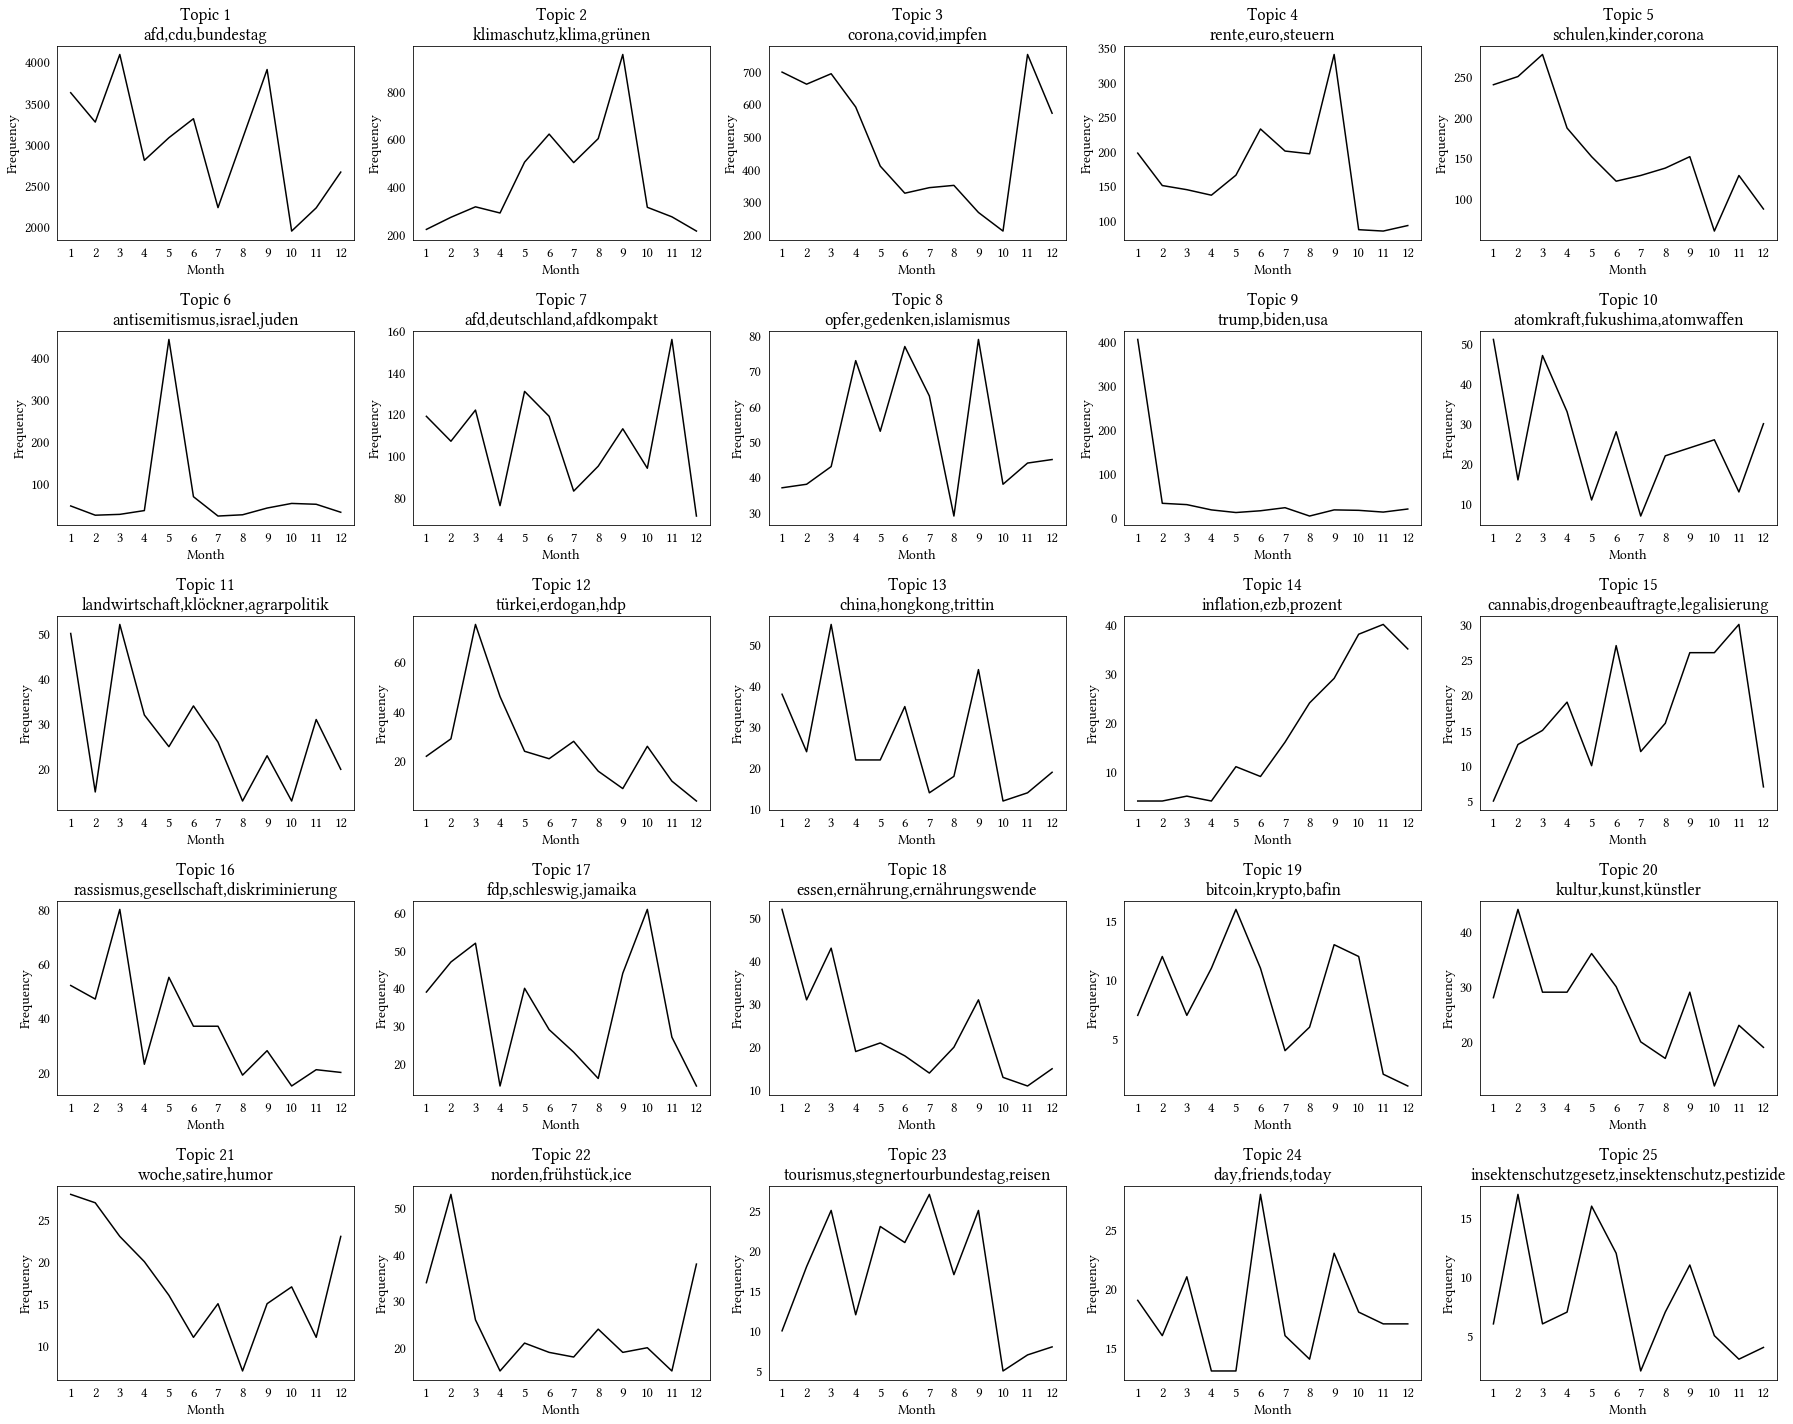

In [30]:
plot_timeseries_subplots(df_topics, n_topics, topics_over_time, filename="plots/timeseries_topics")

#### Sentiment Over Time

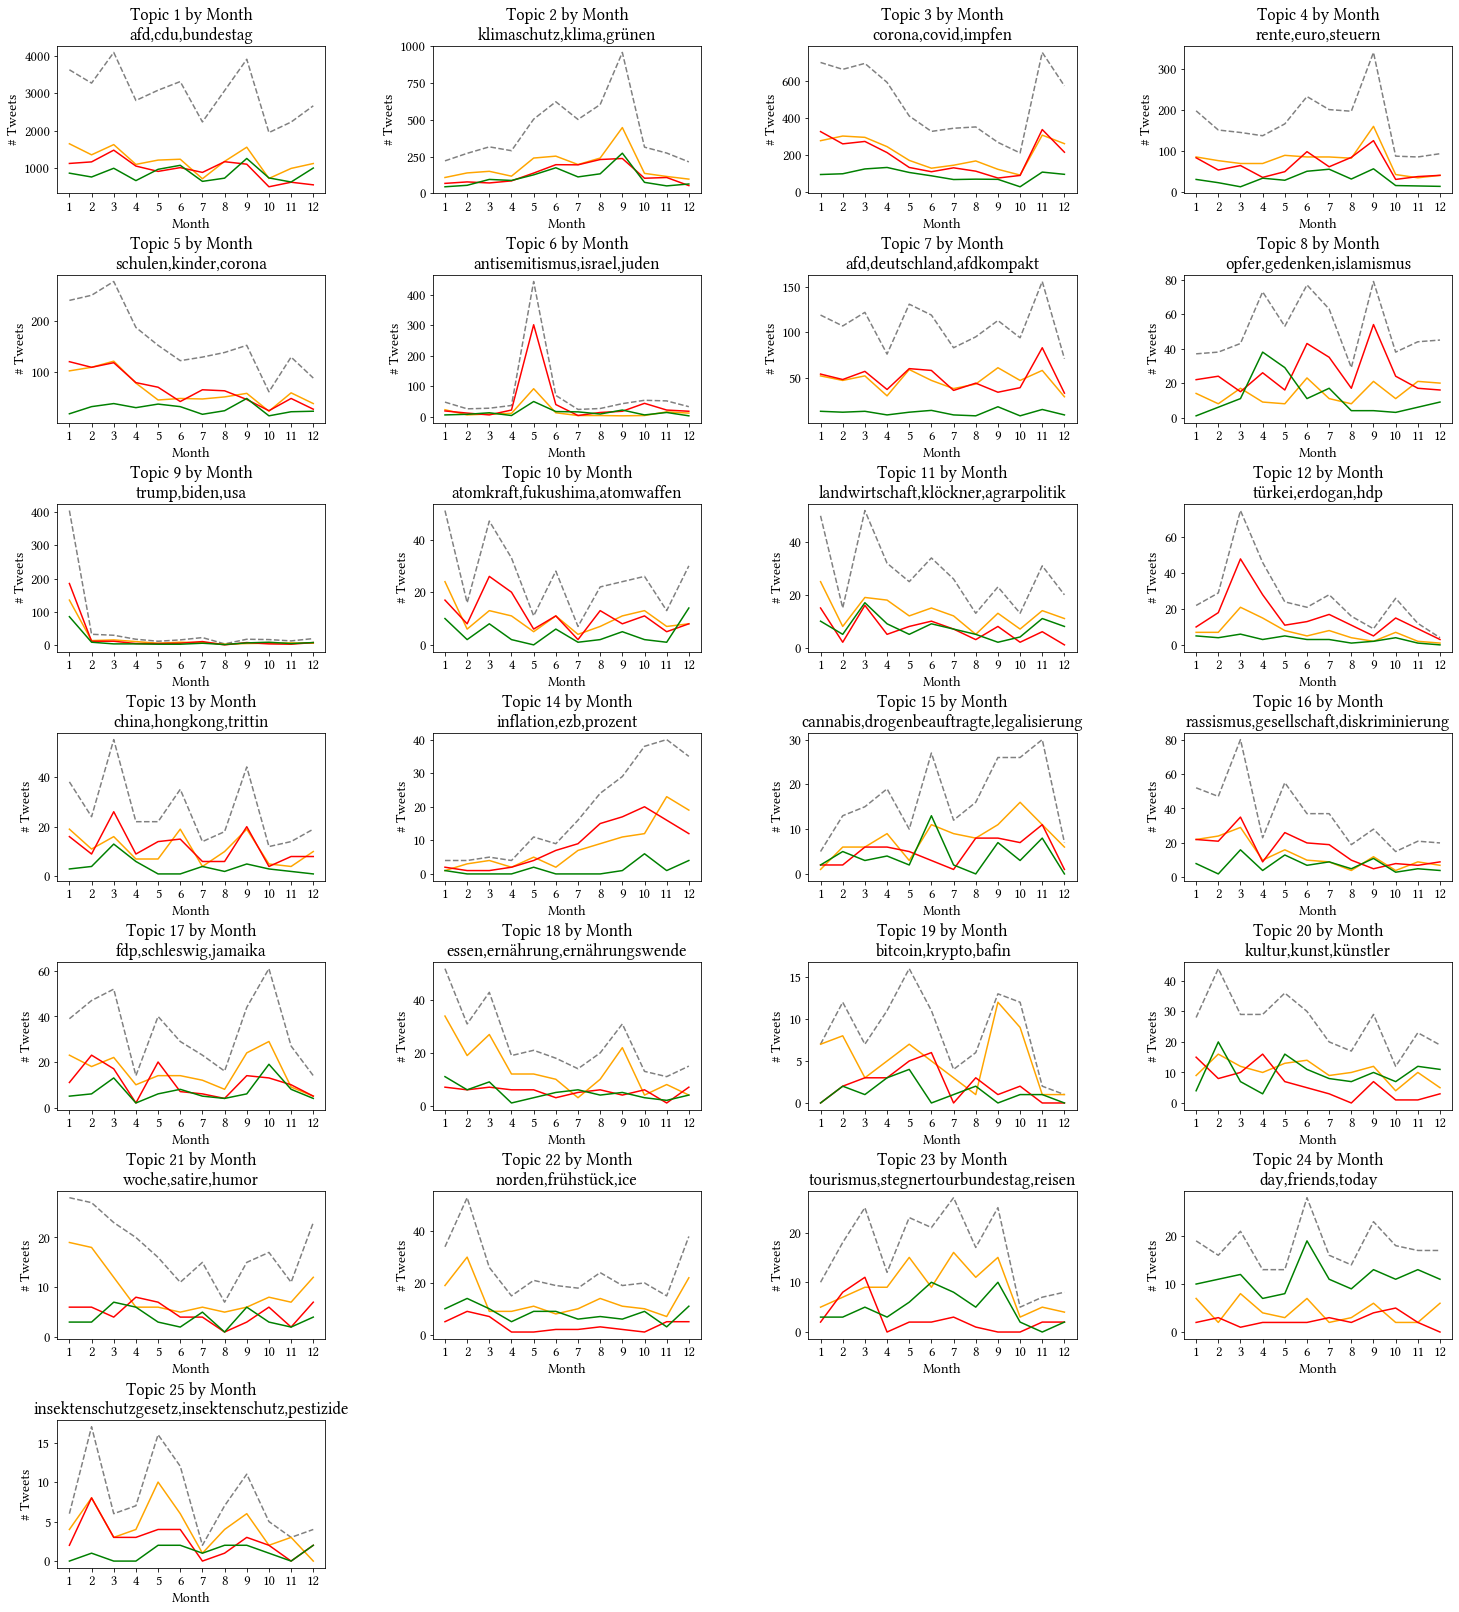

In [31]:
if 'sentiment' in df.columns:
     plot_timeseries_sentiment_subplots(df_topics, n_topics, document_info, topics_over_time, filename="plots/timeseries_sentiment_subplots")

### Create Word Clouds

In [32]:
def svg_to_pdf(svg_filepath, pdf_filepath):
    drawing = svg2rlg(svg_filepath)
    renderPDF.drawToFile(drawing, pdf_filepath)

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wordcloud = WordCloud(background_color="white", max_words=1000, width=1000, height=700, font_path=FONT_PATH_WORDCLOUDS)
    wordcloud.generate_from_frequencies(text)
    
    base_path = f'wordclouds/wordcloud_topic_{topic}'
    
    # Save wordcloud as svg
    wordcloud_svg = wordcloud.to_svg(embed_font=True)
    svg_path = base_path + ".svg"
    f = open(svg_path, "w+")
    f.write(wordcloud_svg)
    f.close()

    # Save wordcloud as png
    png_path = base_path + ".png"
    wordcloud.to_file(png_path)
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

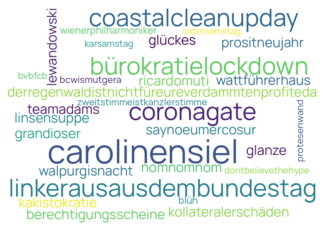

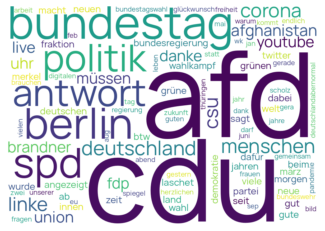

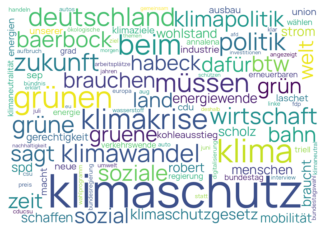

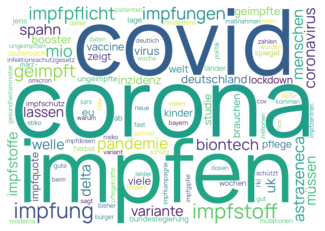

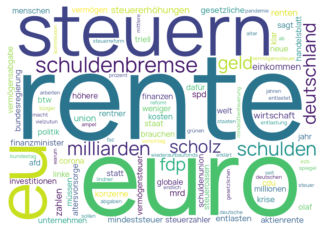

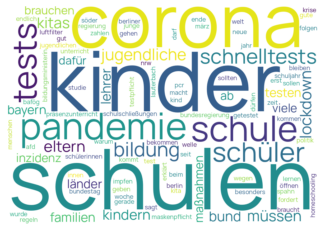

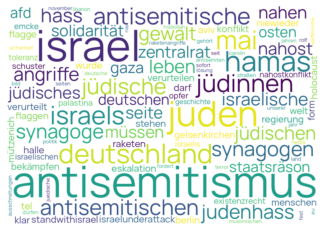

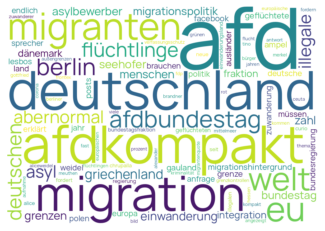

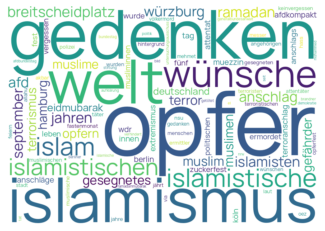

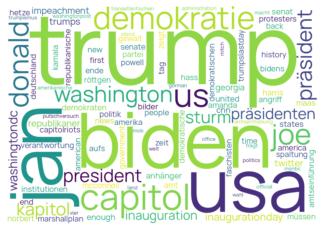

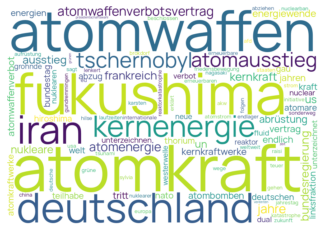

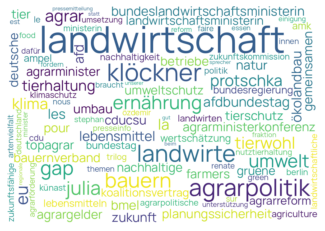

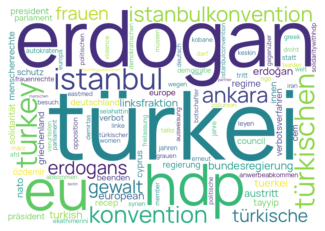

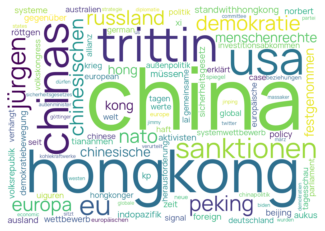

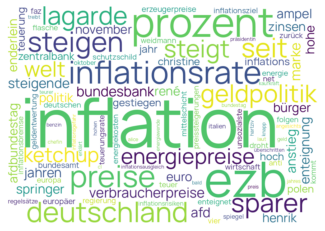

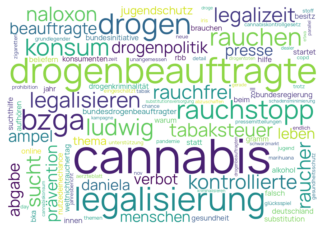

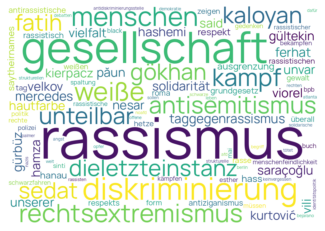

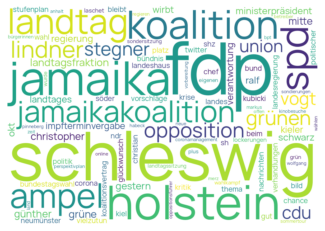

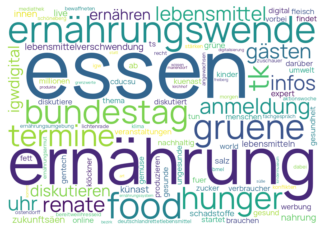

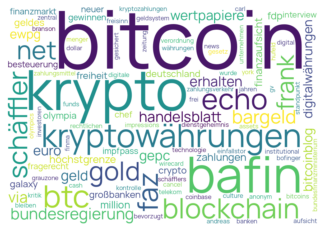

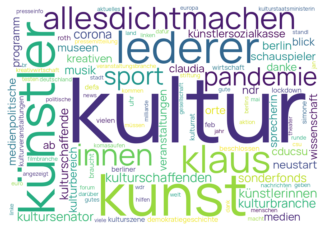

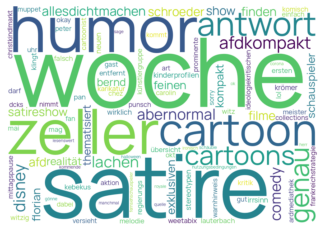

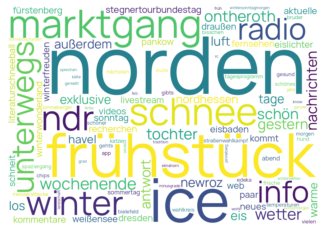

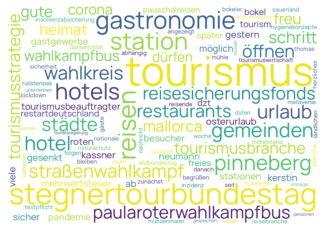

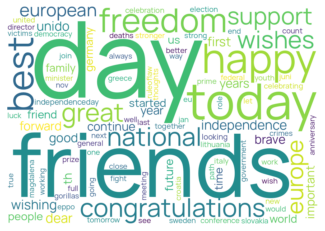

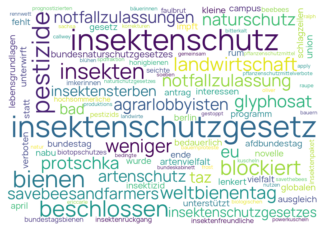

In [34]:
for topic in sorted(document_info["Topic"].unique()):
    create_wordcloud(model, topic=topic)

### Save Model

In [35]:
model.save("politician_model")

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [36]:
#model = BERTopic.load("politician_model")